In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import scipy as scp
from sklearn.decomposition import PCA
from sklearn import preprocessing

### Load data: features and stability scores

In [2]:
stab_sc = pd.read_csv('./final_stability_scores_all.csv',index_col=0)
features = pd.read_csv('./all_new_des_features_saved_regenerated.csv',index_col=0)
features.index = [i.split("_")[0] for i in features.index]
des_with_features_and_stab_sc = []
for i in features.index:
    if i in stab_sc.index:
        des_with_features_and_stab_sc.append(i)
features_clean = pd.concat([features.loc[des_with_features_and_stab_sc],stab_sc.loc[des_with_features_and_stab_sc]], axis=1)
features_clean.to_csv('./final_features_and_stab_sc.csv')

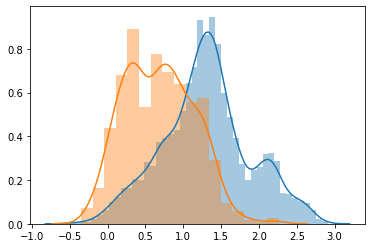

designs=5188.000
scrambles=805.000
Design fraction above threshold: 0.289
Scrambles fraction above threshold: 0.022
False positive ratio above SS=1.55: 0.01


In [3]:
thresh = 1.55
sns.distplot(stab_sc[np.invert(stab_sc.index.str.contains('_'))])
sns.distplot(stab_sc[stab_sc.index.str.contains('scr_')])
plt.show()
print('designs=%0.3f'%sum(np.invert(stab_sc.index.str.contains('_'))))
print('scrambles=%0.3f'%sum(stab_sc.index.str.contains('scr_')))
stable_des_frac = (sum(stab_sc[np.invert(stab_sc.index.str.contains('_'))].stability_sc > thresh))/(sum(np.invert(stab_sc.index.str.contains('_'))))
stable_scr_frac = (sum(stab_sc[stab_sc.index.str.contains('scr_')].stability_sc > thresh))/(sum(stab_sc.index.str.contains('scr_')))
print("Design fraction above threshold: %0.3f"%stable_des_frac)
print("Scrambles fraction above threshold: %0.3f"%stable_scr_frac)

false_positive = (sum(stab_sc[stab_sc.index.str.contains('scr_')].stability_sc > thresh))/((sum(stab_sc[np.invert(stab_sc.index.str.contains('_'))].stability_sc > thresh))+(sum(stab_sc[stab_sc.index.str.contains('scr_')].stability_sc > thresh)))
print("False positive ratio above SS=%0.2f: %0.2f"%(thresh,false_positive))

### Set up for training 

In [4]:
import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV,ElasticNet,Lasso
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import scale, StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [5]:
BB_df = features_clean
terms_given_C={}
allterms = [i for i in BB_df.columns if (i !='stability_sc') ]
scaler = StandardScaler()
scaler.fit(BB_df[allterms])
X=scaler.transform(BB_df[allterms])
y = [ x >= 1.55 for x in BB_df['stability_sc'].values]

/software/conda/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/software/conda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [6]:
# List of regularization constants for Lasso:
Cs = [0.05, 0.045,0.04, 0.035,0.03, 0.025,0.02,0.01,0.008,0.005,0.0048,0.004]

result_summary = {}
for C in Cs:
    result_summary[C] = {}
    for randstate in range(40):
        # Make a different split each time:
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=randstate)
        clf = LogisticRegression(C=C,penalty='l1',class_weight='balanced',random_state=1,solver='liblinear')
        clf.fit(X_train,y_train)
        #C_lists.append(C)
        
        train_proba = [x[1] for x in clf.predict_proba(X_train)]
        test_proba = [x[1] for x in clf.predict_proba(X_test)]
        fpr,tpr,thresholds=roc_curve(y_train,train_proba)
        #plt.plot(fpr,tpr,label=C)
        
        
        terms_n = sum([x != 0 for x in clf.coef_[0]])
        train_auc = roc_auc_score(y_train,train_proba)
        test_auc = roc_auc_score(y_test,test_proba)
        train_score = clf.score(X_train,y_train)
        test_score = clf.score(X_test,y_test)
        train_accuracy = recall_score(y_train,clf.predict(X_train))
        test_accuracy = recall_score(y_test,clf.predict(X_test))
        #print ('C=%s  terms:%s  train_auc=%.3f test_auc=%.3f score_train=%.3f score_test=%.3f, train_acc=%.3f, test_acc=%.3f' %(C,terms_n,train_auc,test_auc,train_score,test_score,train_accuracy,test_accuracy))
        result_summary[C][randstate] = {'test_score':test_score,'test_accuracy':test_accuracy,\
                                        'train_score':train_score,'train_accuracy':train_accuracy,\
                                       'test_auc':test_auc,'train_auc':train_auc,'non_zero_terms':[]}
        
        for coef, term in zip(clf.coef_[0], allterms):
            if coef != 0.0: result_summary[C][randstate]['non_zero_terms'].append((coef,term))

### Plot results

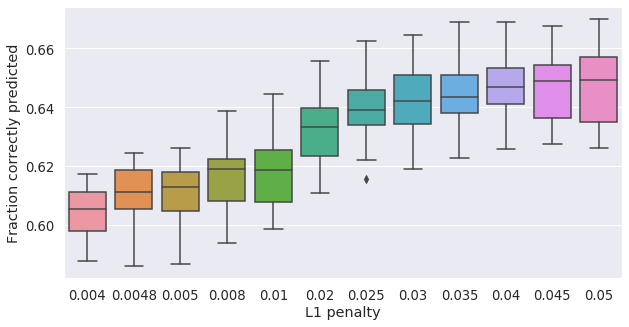

In [7]:
C_vals = sorted([i for i in result_summary.keys()])
C_20_vals = []
test_scores = []
train_scores = []
test_auc_list = []
train_auc_list = []
for i in C_vals:
    for j in range(20):
        C_20_vals.append(i)
        test_scores.append(result_summary[i][j]['test_score'])
        train_scores.append(result_summary[i][j]['train_score'])
        test_auc_list.append(result_summary[i][j]['test_auc'])
        train_auc_list.append(result_summary[i][j]['train_auc'])

sns.set(font_scale=1.2)
fig1,ax1= plt.subplots(1,figsize=(10,5))
#sns.boxplot(np.array(C_20_vals),np.array(test_auc_list))
#plt.legend()
#plt.show()
sns.boxplot(np.array(C_20_vals),np.array(test_scores),ax=ax1)
ax1.set_xlabel('L1 penalty')
ax1.set_ylabel('Fraction correctly predicted')
plt.show()

### Get simplest model
Looks like around L1=0.01 the model performance reaches a plateau, so we are going to look for the simplest model at that value that has a score within one standard deviation of the mean for models with that L1

In [8]:
for i in range(40):
    print(i,len(result_summary[0.02][i]['non_zero_terms']),result_summary[0.02][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.02][i]['non_zero_terms']) for i in range(40)])))

0 31 0.6221959858323495
1 34 0.6162927981109799
2 33 0.6558441558441559
3 28 0.6322314049586777
4 42 0.6393152302243211
5 35 0.6157024793388429
6 29 0.640495867768595
7 30 0.6458087367178277
8 36 0.627508854781582
9 30 0.6387249114521841
10 35 0.6446280991735537
11 31 0.6239669421487604
12 29 0.6369539551357734
13 37 0.6192443919716647
14 33 0.6322314049586777
15 28 0.6340023612750886
16 39 0.6463990554899646
17 35 0.6109799291617474
18 32 0.6381345926800472
19 27 0.6328217237308147
20 33 0.6204250295159386
21 30 0.6298701298701299
22 34 0.6263282172373081
23 40 0.6351829988193625
24 33 0.6322314049586777
25 33 0.6251475796930342
26 28 0.6363636363636364
27 30 0.640495867768595
28 36 0.6115702479338843
29 27 0.6198347107438017
30 30 0.6298701298701299
31 35 0.6440377804014168
32 34 0.6393152302243211
33 31 0.6292798110979929
34 32 0.6363636363636364
35 32 0.6369539551357734
36 33 0.6381345926800472
37 31 0.6198347107438017
38 33 0.6269185360094451
39 33 0.615112160566706
Average n feat

In [9]:
# The simplest model is random partition=16, lets look at it:
for i in sorted(result_summary[0.02][19]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(0.2642004000055821, 'hphob_sc_contacts')
(0.21508805577813425, 'BuriedHyphobSAperRes')
(0.12659343086634758, 'dsc_av')
(-0.11213574585416626, 'score_res_betacart')
(-0.09357324494650836, 'nres_H')
(-0.08147750421341358, 'loop3_flank_av_worstfr')
(-0.07287981150026282, 'av_all_strand')
(0.06655730716571764, 'ssc_av')
(0.06090516514110093, 'T1_absq')
(-0.04833731509223315, 'buns_nosurf_sc')
(0.03990386651122402, 'H3_n_dsc50_worst')
(-0.03908882717212575, 'N-term_helix_av_allfr')
(0.031217998857974563, 'HolesCorSAS')
(0.024250684914221804, 'tryp_cut_sites')
(0.022879019629514826, 'str3_4_dsc50_av')
(0.022379384449665415, 'str4_5_av_allfr')
(0.021364081568381394, 'H3_n_ssc50_worst')
(-0.020621541517733866, 'str5_6_av_worstfr')
(0.019868550748001687, 'H3C_str3_abd50_worst')
(0.018211537180774746, 'H1H2_link_dsc50_av')
(-0.012422254789813921, 'buns_all')
(0.011994764640920372, 'HolesCorSCN')
(-0.011113932069768906, 'H3_av_worstfr')
(0.011009024460289738, 'fa_intra_rep')
(0.00965036536198907

### Get feature importance

In [10]:
terms = []
for i in range(40):
    for j in result_summary[0.02][i]['non_zero_terms']:
        terms.append(j[1])

didt_for_df = {i:{ j:0 for j in terms} for i in range(40)}
        
for i in range(40):
    for j in result_summary[0.02][i]['non_zero_terms']:
        didt_for_df[i][j[1]] = j[0]
        #didt_for_df[i][j[1]] = abs(j[0])

models_df = pd.DataFrame.from_dict(didt_for_df,orient='index')

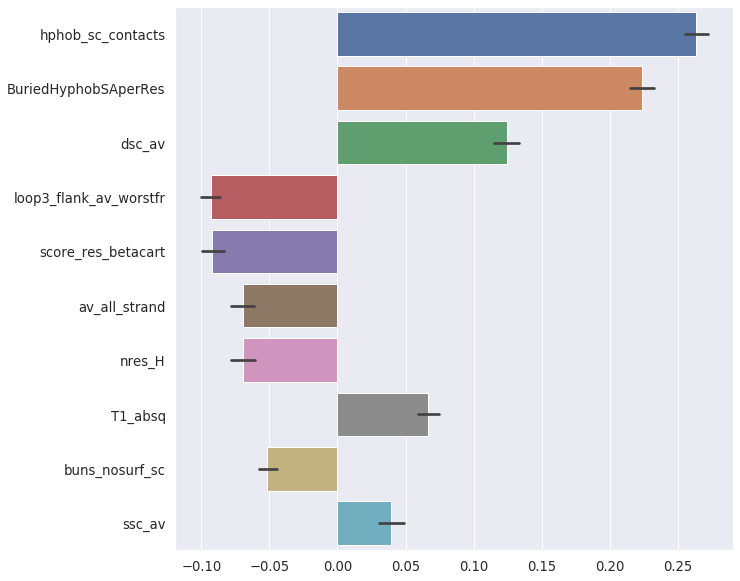

In [19]:
fig2,ax2= plt.subplots(1,figsize=(10,10))
sorted_terms_by_av = sorted( [(t,abs(np.average(models_df[t]))) for t in set(terms)], key=lambda x:x[1]  )
top_15_terms = [i for i in reversed([t[0] for t in sorted_terms_by_av][-10:])]
sns.barplot(data=models_df[top_15_terms],orient='h',ax=ax2)
#ax2.set_xlabel('Features')
#ax2.set_ylabel('Weight absolute value')
plt.show()

In [20]:
models_df[top_15_terms]

,hphob_sc_contacts,BuriedHyphobSAperRes,dsc_av,loop3_flank_av_worstfr,score_res_betacart,av_all_strand,nres_H,T1_absq,buns_nosurf_sc,ssc_av
0,0.281187,0.205284,0.121903,-0.113286,-0.131330,-0.104699,-0.086562,0.012650,-0.024732,0.107426
1,0.267065,0.247989,0.115640,-0.120025,-0.062207,-0.056900,-0.069422,0.085328,-0.052055,0.036273
2,0.296690,0.165625,0.112176,-0.105139,-0.108880,-0.079748,-0.047166,0.003738,-0.048429,0.012123
3,0.255647,0.287347,0.124211,-0.081120,-0.084287,-0.056648,-0.091729,0.075152,-0.033760,0.055934
4,0.283500,0.215126,0.111680,-0.129066,-0.092989,-0.051761,-0.086222,0.086881,-0.056452,0.031453
5,0.286925,0.183884,0.115535,-0.093668,-0.084705,-0.003993,-0.025631,0.071593,-0.080928,0.074161
6,0.270017,0.183997,0.117896,-0.162235,-0.084517,-0.043951,-0.089718,0.082506,-0.054626,0.043499
7,0.246251,0.274816,0.070589,-0.131558,-0.066789,-0.037987,-0.057141,0.087342,-0.060255,0.091084
8,0.270080,0.205249,0.136141,-0.083833,-0.104432,-0.019231,-0.043379,0.074826,-0.086627,0.000000
9,0.281891,0.161245,0.127036,-0.104666,-0.087164,-0.067045,-0.035557,0.089329,-0.057901,0.000000


### Get correlation matrix for simplest model

(10, 0)

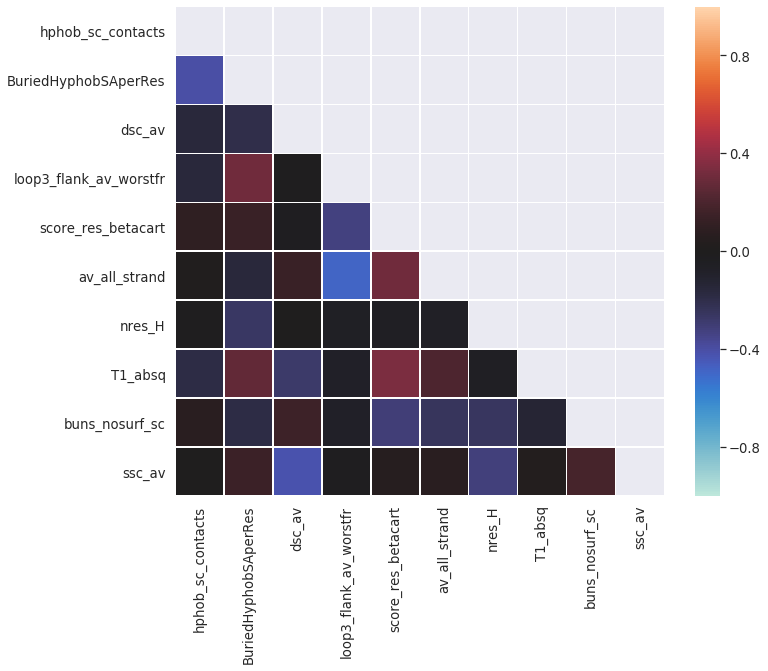

In [22]:
simplest_model_features = [i[1] for i in result_summary[0.01][2]['non_zero_terms']]
specific_df = models_df[top_15_terms]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)
plt.ylim(10,0)

### Get correlation matrix for 15 most important features in all (40) models

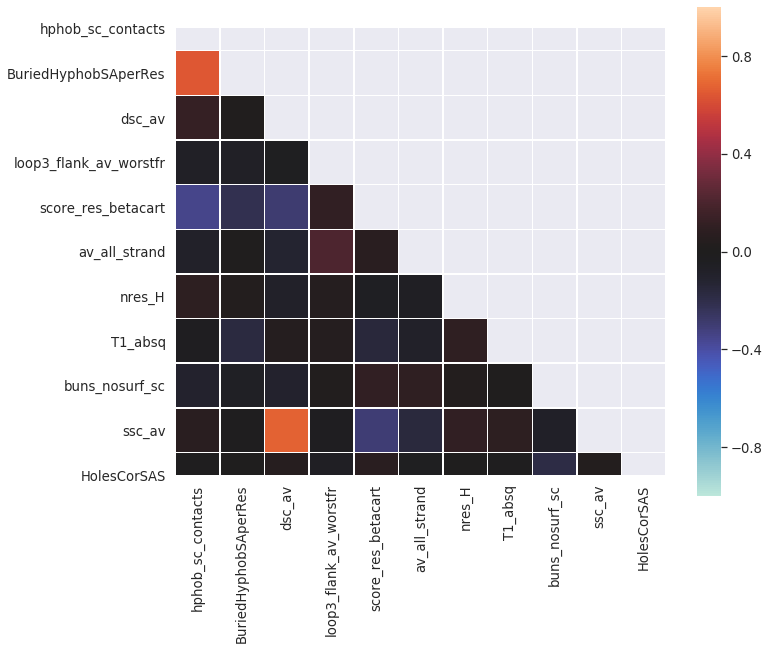

In [16]:
specific_df = features_clean[top_15_terms]
corr = specific_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5)

### What are the less complex models at L1=0.008?

In [17]:
for i in range(40):
    print(i,len(result_summary[0.008][i]['non_zero_terms']),result_summary[0.008][i]['test_score'])
print('Average n features: %d'%(np.average([len(result_summary[0.008][i]['non_zero_terms']) for i in range(40)])))

0 9 0.6033057851239669
1 7 0.5938606847697757
2 10 0.6387249114521841
3 7 0.6139315230224321
4 9 0.6221959858323495
5 10 0.6092089728453365
6 6 0.6174734356552538
7 9 0.6227863046044865
8 9 0.6198347107438017
9 7 0.6233766233766234
10 7 0.6328217237308147
11 10 0.6056670602125147
12 9 0.6310507674144038
13 11 0.6009445100354192
14 10 0.6204250295159386
15 9 0.6186540731995277
16 8 0.6204250295159386
17 10 0.6050767414403778
18 9 0.6221959858323495
19 7 0.6092089728453365
20 10 0.5985832349468713
21 10 0.6162927981109799
22 10 0.6056670602125147
23 9 0.6133412042502951
24 7 0.6033057851239669
25 9 0.602125147579693
26 7 0.615112160566706
27 7 0.60271546635183
28 8 0.5985832349468713
29 8 0.6062573789846517
30 10 0.6080283353010626
31 10 0.615112160566706
32 8 0.6133412042502951
33 12 0.60271546635183
34 7 0.614521841794569
35 6 0.6103896103896104
36 6 0.6162927981109799
37 6 0.6109799291617474
38 10 0.6139315230224321
39 7 0.6044864226682408
Average n features: 8


In [18]:
# The simplest model is random partition=4, lets look at it:
for i in sorted(result_summary[0.008][19]['non_zero_terms'],key=lambda x:abs(x[0]),reverse=True):
    print(i)

(0.24953644004843314, 'hphob_sc_contacts')
(0.1346031247407052, 'dsc_av')
(0.1219691148734512, 'BuriedHyphobSAperRes')
(-0.09312005289784268, 'score_res_betacart')
(0.028150449941691393, 'ssc_av')
(-0.015306747389354497, 'loop3_flank_av_worstfr')
(-0.004458080960253506, 'av_all_strand')


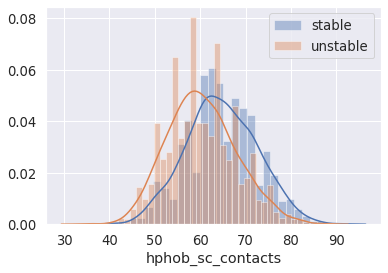

In [19]:
sns.distplot(features_clean.hphob_sc_contacts.where(features_clean.stability_sc > 1.55).dropna(), label='stable')
sns.distplot(features_clean.hphob_sc_contacts.where(features_clean.stability_sc <= 1.55).dropna(), label='unstable')
plt.legend()

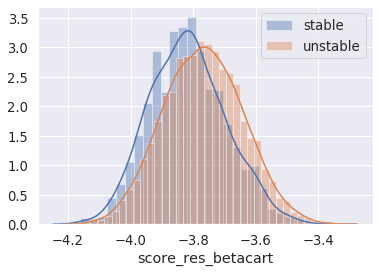

In [20]:
sns.distplot(features_clean.score_res_betacart.where(features_clean.stability_sc > 1.55).dropna(), label='stable')
sns.distplot(features_clean.score_res_betacart.where(features_clean.stability_sc <= 1.55).dropna(), label='unstable')
plt.legend()

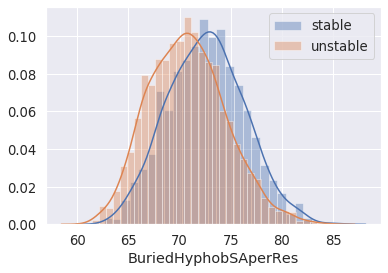

In [21]:
sns.distplot(features_clean.BuriedHyphobSAperRes.where(features_clean.stability_sc > 1.55).dropna(), label='stable')
sns.distplot(features_clean.BuriedHyphobSAperRes.where(features_clean.stability_sc <= 1.55).dropna(), label='unstable')
plt.legend()

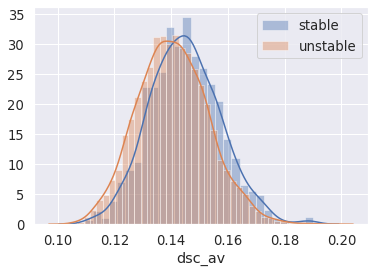

In [22]:
sns.distplot(features_clean.dsc_av.where(features_clean.stability_sc > 1.55).dropna(), label='stable')
sns.distplot(features_clean.dsc_av.where(features_clean.stability_sc <= 1.55).dropna(), label='unstable')
plt.legend()